# Wind Speed Determination from a multirotor attitude during flight
## Introduction
Imagine a rod projecting vertically from the centre of a a multicopter's frame. The rod is normal to the plane formed by the arms and propellers of the copter. At rest the rod will also be normal to the XY plane in the earth frame of reference and as such can be represented by the unit vector [0,0,-1]. The Z-axis in the standard aircraft reference from increases going down. During flight the rod will "lean" into the apparent wind. The lean will be proportional to the relative air speed moving across the airframe and dependant on the drag profile of the airframe / rotor wash.

The wind speed can be found from the identity relating wind the wind vector, the flight vector and the ground vector. 

F = W + G

Since the multirotor will lean into the direction of the apparent wind the flight vector can be thought of as the projection of the rod onto the XY plane. [Note: In this case only the horizontal wind speed is being considered. However, I suspect that the potential exists to work in 3D.] 

The multirotor flight controller reports yaw, pitch and roll angles for the copter. The projection of the rod onto XY is found by applying a rotation matrix defined by these angles to the unit vector described above i.e. the rod. Once the rod has been rotated by this rotation matrix the projecting of the resulting vector on to the XY plane will represent the flight vector but will need to be multiplied by a factor dependent on the drag characteristics of the frame.

This factor can be determined experimentally by plotting a curve of the "lean" angle vs. a known air speed.

## Code
Setup the python environment

In [1]:
%matplotlib inline
from csv import reader
import datetime, calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import transforms3d.euler as eu

## Calibration curve
This is a fake calibration curve until I extract the wind tunnel data:

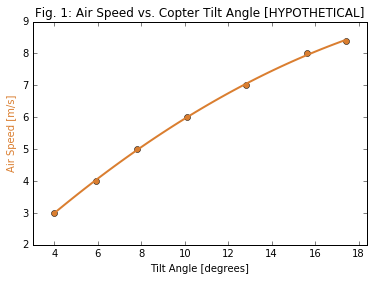

In [7]:
calib = np.array([[4,3],[5.9,4],[7.8,5],[10.1,6],[12.8,7],[15.6,8],[17.4,8.4]])
fig, ax1 = plt.subplots()
x=calib[:,0]
y=calib[:,1]
z = np.polyfit(x,y, 2)
f = np.poly1d(z)
# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)
ax1.set_title("Fig. 1: Air Speed vs. Copter Tilt Angle [HYPOTHETICAL]")
ax1.set_xlabel('Tilt Angle [degrees]')
ax1.set_ylabel('Air Speed [m/s]', color='#DA7E30')
ax1.plot(x,y,'o', x_new, y_new, color='#DA7E30',lw=2)
ax1.set_xlim([x[0]-1, x[-1] + 1 ])
plt.show()
fig.savefig("./output/calibration.pdf")


In [2]:
datetimeformat = "%Y-%m-%dT%H:%M:%S"

start_time = datetime.datetime.strptime('2016-11-15T01:03:00',datetimeformat)
end_time = datetime.datetime.strptime('2016-11-15T23:10:30',datetimeformat)

# basic unit vectors
norm_xy=[0,0,-1]
inv_norm_xy=[0,0,-1]
norm_xz=[0,1,0]
norm_yz=[1,0,0]
resample_period = '5S'

# Heading for:
# psi - angle to the norm_xy 
# lamda - the angle the projection of copter_norm onto XY makes with 0
# this is the flight direction
# Init arrays to hold values:
n_rp_array = []
psi_array = []
copter_norm_array=[]
lamda_array = []

df_att_proto=[]
df_gps_proto=[]
df_imet_proto=[]

#calib = np.array([[4,2],[5.9,3],[7.8,4],[10.1,5],[12.8,6],[15.6,7],[17.4,7.4]])
calib = np.array([[4,3],[5.9,4],[7.8,5],[10.1,6],[12.8,7],[15.6,8],[17.4,8.4]])
x=calib[:,0]
y=calib[:,1]
z = np.polyfit(x,y, 2)
fit = np.poly1d(z)

# calculate new x's and y's
#x_new = np.linspace(x[0], x[-1], 50)
#y_new = f(x_new)

#https://gist.github.com/jeremiahajohnson/eca97484db88bcf6b124
def weeksecondstoutc(gpsweek,gpsseconds,leapseconds):
    epoch = datetime.datetime.strptime("1980-01-06T00:00:00",datetimeformat)
    elapsed = datetime.timedelta(days=(gpsweek*7),seconds=(gpsseconds+leapseconds))
    return(epoch+elapsed)
    #return datetime.datetime.strftime(epoch + elapsed,datetimeformat)


with open('./input/in.txt') as f:
    init_time = True
    have_GPS = False
    init_TimeUS = 0
    line_num = 0
    for line in reader(f):
        line_num += 1
         # Get the headers for ATT and GPS
        #if(line[0].strip()=='FMT'):
        #    if(line[3].strip()=='GPS'):
        #        header_GPS = line
        #        next
        #    if(line[3].strip()=='ATT'):
        #        header_ATT = line
        #        next
        TimeUS = int(line[1])
        if(line[0].strip()=='GPS' and line[2].strip()>='1' and init_time):
            gps_GMS = int(line[3])/1000
            gps_GWk = int(line[4])
            #gpsTime = weeksecondstoutc(gps_GWk,gps_GMS,16)
            print (line)
            init_TimeUS = TimeUS
            init_gpsTime = weeksecondstoutc(gps_GWk,gps_GMS,16)
            print ( repr(init_TimeUS), repr(init_gpsTime))
            init_time = False
        else:
            #init_gpsTime = datetime.datetime.fromtimestamp(TimeUS/1000)
            init_gpsTime = start_time
            #print("NO GPS Time - using start_time as init_gpsTime")
        if init_time:
            #print("Next...")
            continue
        elapsedmicros = TimeUS - init_TimeUS
        log_time = init_gpsTime + datetime.timedelta(microseconds=elapsedmicros)
        if log_time < start_time or log_time > end_time:
            continue
        else:
            #log_time = datetime.datetime.fromtimestamp(TimeUS)
            #print(line_num,log_time)
            if(line[0].strip()=='GPS'):
                have_GPS = True
                TimeUS = int(line[1])
                elapsedmicros = TimeUS - init_TimeUS
                TimeUS = init_gpsTime + datetime.timedelta(microseconds=elapsedmicros)
                (groundspeed,heading)=(float(line[10]),float(line[11]))
                ground_vect = [groundspeed * np.cos(np.radians(heading)),groundspeed * np.sin(np.radians(heading))]
                #print(groundspeed,heading,ground_vect)
                df_gps_proto.append([TimeUS,groundspeed,heading,ground_vect[0],ground_vect[1]])
            if(line[0].strip()=='AHR2') and have_GPS:
                # TimeUS, Roll, Pitch, Yaw
                TimeUS = int(line[1])
                elapsedmicros = TimeUS - init_TimeUS
                TimeUS = init_gpsTime + datetime.timedelta(microseconds=elapsedmicros)
                #(Roll, Pitch, Yaw) = (float(line[3]),float(line[5]),float(line[7]))
                (Roll, Pitch, Yaw, Alt) = (float(line[2]),float(line[3]),float(line[4]),float(line[5]))
                #print (repr(TimeUS),repr(Roll),repr(Pitch),repr(Yaw))
                # So what's the rotation matrix
                R = eu.euler2mat(np.radians(Yaw),np.radians(Pitch),np.radians(Roll), 'rzyx')
                #print(R)
                # multiply norm_xy by the rotation matrix to produce the rotated vector normal to the copter
                copter_norm = np.dot(R,norm_xy)
                copter_norm_array.append(copter_norm)
                #print(copter_norm)
                psi = np.degrees(np.arccos((np.dot(norm_xy,copter_norm))/ \
                                           (np.dot(np.linalg.norm(norm_xy),np.linalg.norm(copter_norm)))))
                #psi_array.append(psi)
                # project the copter_norm onto the xy plane
                # For now this is a unit vector. After calibration the magnitude will be corrected
                flight_vect = copter_norm - np.multiply((np.dot(copter_norm,norm_xy))/ \
                                                        (np.dot(norm_xy,norm_xy)) , norm_xy)
                #print(flight_vect)
                if(flight_vect[1]>=0):
                    lamda = np.degrees(np.arctan2(flight_vect[1],flight_vect[0]))
                else:
                    lamda = 360 + np.degrees(np.arctan2(flight_vect[1],flight_vect[0]))

                # scale the flight vector from the wind tunnel calibration curve
                #print(psi)
                scale_factor = fit(float(psi))/(np.sqrt(flight_vect[1]**2+flight_vect[0]**2))
                flight_vect = scale_factor * flight_vect
                #print(flight_vect)
                #print(TimeUS,Roll,Pitch,Yaw,psi,lamda)
                df_att_proto.append([TimeUS,Roll,Pitch,Yaw,Alt,psi,lamda,flight_vect[0],flight_vect[1]])

    df_att=pd.DataFrame(data=df_att_proto,columns=['TimeUS','Roll','Pitch','Yaw','Alt','psi','lamda','flight_vect_x','flight_vect_y'])
    df_att.set_index(['TimeUS'],inplace=True)
    df_gps=pd.DataFrame(data=df_gps_proto,columns=['TimeUS','groundspeed','heading','ground_vect_x','ground_vect_y'])
    df_gps.set_index(['TimeUS'],inplace=True)
    #print(df_att)
    #print(df_gps)
    #df_att.loc[:,['flight_vect_x','flight_vect_y']].plot()
 

['GPS', ' 82762815', ' 1', ' 0', ' 0', ' 0', ' 99.99', ' 0', ' 0', ' -17.00', ' 0', ' 0', ' 0', ' 1']
82762815 datetime.datetime(1980, 1, 6, 0, 0, 16)


In [3]:
# Have to resample to a consistent time as AHR2 and GPS are at different frequencies!!!!
df_att_resampled = df_att.loc[:,['psi','lamda','Roll','Pitch','Yaw','Alt','flight_vect_x','flight_vect_y']].resample(resample_period).mean()
df_gps_resampled = df_gps.loc[:,['groundspeed','heading','ground_vect_x','ground_vect_y']].resample(resample_period).mean()

#print(df_att_resampled) 
#print(df_gps_resampled)
#df_att_resampled.loc[:,['lamda','Yaw','Alt']].plot()
#df_att_resampled.loc[:,['psi','Pitch','Roll']].plot()



In [4]:
# Calculate the wind speed by adding the ground_vect and flight_vect
wind_vect_x = df_att_resampled['flight_vect_x']+df_gps_resampled['ground_vect_x']
wind_vect_y = df_att_resampled['flight_vect_y']+df_gps_resampled['ground_vect_y']
wind_vect_x.name='wind_vect_x'
wind_vect_y.name='wind_vect_y'
#print(wind_vect_x,wind_vect_y)
ws_vect=pd.concat([wind_vect_x,wind_vect_y],axis=1)
#print(ws_vect['wind_vect_x'])
ws_vect['speed']=ws_vect.apply(lambda x: np.sqrt(x.wind_vect_x**2+x.wind_vect_y**2), axis=1)

ws_vect['direction']=ws_vect.apply(lambda x: \
            ( np.degrees(np.arctan2(x.wind_vect_y,x.wind_vect_x))) if (x.wind_vect_y>=0) else \
            ( 360 + np.degrees(np.arctan2(x.wind_vect_y,x.wind_vect_x))) ,axis=1)

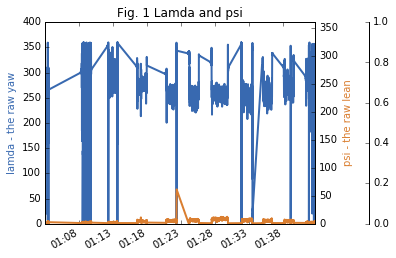

In [8]:
fig, ax = plt.subplots()

axes = [ax, ax.twinx(), ax.twinx()]
axes[-1].spines['right'].set_position(('axes', 1.2))
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# A plot of lamda and psi
#fig, ax1 = plt.subplots()
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].set_title('Fig. 1 Lamda and psi')
fig.autofmt_xdate()
axes[0].plot(df_att['lamda'], color='#3869B0',lw=2)
axes[1].plot(df_att['psi'], color='#DA7E30',lw=2)
axes[1].set_ylim([0, 360 ])
axes[1].set_xlabel('Time')
axes[0].set_ylabel('lamda - the raw yaw', color='#3869B0')
axes[1].set_ylabel('psi - the raw lean', color='#DA7E30')
plt.show()
fig.savefig("./output/lamda-psi.pdf")



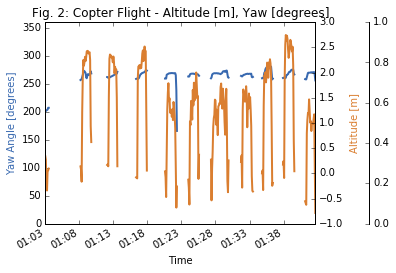

In [10]:
fig, ax = plt.subplots()

axes = [ax, ax.twinx(), ax.twinx()]
axes[-1].spines['right'].set_position(('axes', 1.2))
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].set_title('Fig. 2: Copter Flight - Altitude [m], Yaw [degrees]')
fig.autofmt_xdate()
axes[0].plot(df_att_resampled['Yaw'], color='#3869B0',lw=2)
axes[1].plot(df_att_resampled['Alt'], color='#DA7E30',lw=2)
axes[0].set_ylim([0, 360 ])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Yaw Angle [degrees]', color='#3869B0')
axes[1].set_ylabel('Altitude [m]', color='#DA7E30')
plt.show()
fig.savefig("./output/copter-flight.pdf")
    

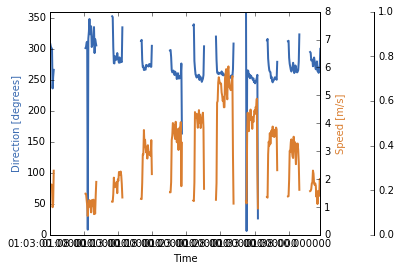

In [11]:
fig, ax = plt.subplots()

axes = [ax, ax.twinx(), ax.twinx()]
axes[-1].spines['right'].set_position(('axes', 1.2))
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[0].plot(ws_vect['direction'], color='#3869B0',lw=2)
axes[1].plot(ws_vect['speed'], color='#DA7E30',lw=2)
axes[0].set_ylim([0, 360 ])
axes[1].set_ylim([0, 8 ])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Direction [degrees]', color='#3869B0')
axes[1].set_ylabel('Speed [m/s]', color='#DA7E30')
plt.show()
fig.savefig("./output/direction.pdf")